# PROJECT TITLE

# Business Understanding

# Data Understanding

# Data Preparation

## Preprocessing

Let's start by importing modules necessary for analysis and reading in the data.

In [34]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [35]:
df = pd.read_csv('judge-1377884607_tweet_product_company.csv',encoding= 'unicode_escape')
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


Let's convert the sentences contained in the `tweet_text` column to type `string` for later analysis.

In [36]:
df['tweet_text'] = df['tweet_text'].astype(str)

Let's also rename the columns so that they are more readable.

In [37]:
df.rename(columns={"emotion_in_tweet_is_directed_at": "product", "is_there_an_emotion_directed_at_a_brand_or_product": "emotion"},inplace=True)

We would like to classify the tweets on whether they are about Google or Apple. So, we first group all Google related `product` column values as Google and also group all Apple related `product` column values as Apple. Then, since there are many tweets that are have unknown `product` labels, we search for different substrings in these tweets to in order to assign them to either Apple or Google categories. 

In [38]:
df["product"].fillna("none", inplace = True)
df_none = df.loc[df["product"] == 'none']

apple_condition = (df['product'] == "iPad") | (df['product'] == "iPad or iPhone App") | (df['product'] == "iPhone") | (df['product'] == "Other Apple product or service")
google_condition = (df['product'] == "Other Google product or service") | (df['product'] == "Android App") | (df['product'] == "Android") 
df.loc[apple_condition,'product'] = "Apple"
df.loc[google_condition, 'product'] = "Google"

# apple loop
for word in ["Apple","iphone","apple","ipad","ipad2","iPad 2","iPhone","iPad"]:
    temp_df = df_none[df_none['tweet_text'].str.contains(word)]
    temp_df['product'].replace({'none': 'Apple'}, inplace=True)
    df_none = temp_df.combine_first(df_none)
# google loop
for word in ["Google","google","Android","android"]:
    temp_df = df_none[df_none['tweet_text'].str.contains(word)]
    temp_df['product'].replace({'none': 'Google'}, inplace=True)
    df_none = temp_df.combine_first(df_none)
df_1 = df_none.combine_first(df)

Next, drop the tweets that could not be assigned to a product. Also drop tweets that convey no emotion. 

In [39]:
df_1 = df_1[df_1['product'] != "none"]
df_1 = df_1[df_1['emotion'] != "I can't tell"]

In [40]:
df_1["emotion"].value_counts()

No emotion toward brand or product    4599
Positive emotion                      2962
Negative emotion                       569
Name: emotion, dtype: int64

In [41]:
df_1["product"].value_counts()

Apple     5384
Google    2746
Name: product, dtype: int64

Now that `emotion` and `product` columns are preprocessed, let's focus on preprocessing the `tweet_text` column. We'll start by using regex in order to filter some characters and phrases from tweets.

In [42]:
import re
# function to clean text
def cleaner(tweet):
    tweet = re.sub(r'@[A-Za-z0-9]+','', str(tweet)) # removes @
    tweet = re.sub(r'#', '', str(tweet)) # removes hashtag
    tweet = re.sub(r'RT[\s]+','', str(tweet)) # removes RT
    tweet = re.sub(r'https?:\/\/\S+', '', tweet) # remove hyperlink in tweet
    tweet = re.sub(r'[^\w\s]', '', tweet) # removes punctuations
    #tweet = re.sub(r'[^a-zA-Z]','', tweet)
    return tweet

df_1['tweet_text'] = df_1['tweet_text'].apply(cleaner)

Next, let's perform some feature engineering on the tweets. In the following cell, let's initiate the tokenizaton, stopword removal and lemmatization of the tweets. 

In [43]:
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer


tokenizer = RegexpTokenizer(r"(?u)\w{3,}[a-zA-Z]")

stopwords_list = stopwords.words('english')

lemmatizer = WordNetLemmatizer()

def lemmatize_and_tokenize(text):
    tokens = tokenizer.tokenize(text)
    return [lemmatizer.lemmatize(token) for token in tokens]

There is a clear class imbalance in the target variable `emotion` that can be visualized the cell below.

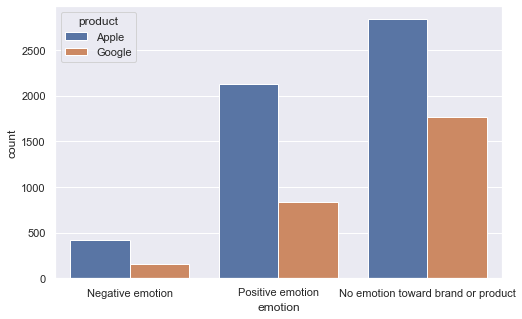

In [44]:
import seaborn as sns
# sns.set(rc={'figure.figsize':(8,5)})
sns.countplot(df_1['emotion'], hue=df_1['product']);

The models require the target variable to be of integer type, so let's assign 0 to `Negative emotion`, 1 to `No emotion toward brand or product` and 2 to `Positive emotion`.

In [45]:
def number_map(x):
    if x == 'Positive emotion':
        return 2
    elif x == 'No emotion toward brand or product':
        return 1
    else:
        return 0

In [46]:
df_1['emotion'] = df_1['emotion'].apply(number_map)

## TRAIN TEST SPLIT

In [47]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_1.drop('emotion',axis=1), df_1['emotion'], random_state=42)

## Addressing Class Imbalance using imblearn

In [48]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

In [49]:
ros = RandomOverSampler(random_state=42)

# fit predictor and target variable
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

# print('Old shape of y:' + str(Counter(y)))
# print('New shape of y:' + str(Counter(y_ros)))

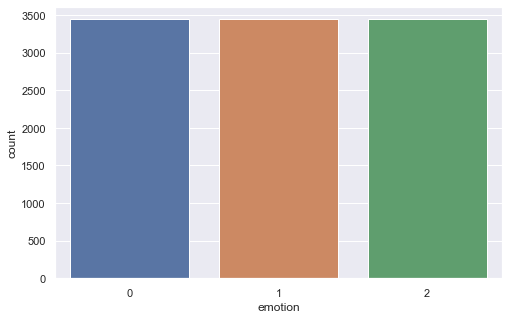

In [50]:
sns.countplot(y_train_ros);

In [51]:
X_train_ros['product'].value_counts()

Apple     7178
Google    3145
Name: product, dtype: int64

## Modeling

In [52]:
# Import the relevant vectorizer class
from sklearn.feature_extraction.text import TfidfVectorizer

# Instantiate a vectorizer with max_features=10
# (we are using the default token pattern)
tfidf = TfidfVectorizer(max_features=500, stop_words=stopwords_list, tokenizer=lemmatize_and_tokenize, strip_accents='ascii')

# Fit the vectorizer on X_train["text"] and transform it
X_train_ros_vectorized = tfidf.fit_transform(X_train_ros["tweet_text"])
# Visually inspect the vectorized data
X_train_df = pd.DataFrame.sparse.from_spmatrix(X_train_ros_vectorized, columns=tfidf.get_feature_names())

In [53]:
# transforming the test data
X_test_vectorized = tfidf.transform(X_test['tweet_text'])
X_test_df = pd.DataFrame.sparse.from_spmatrix(X_test_vectorized, columns=tfidf.get_feature_names())

## Decision Tree

In [54]:
# function to evaluate the model
from sklearn.metrics import plot_confusion_matrix, classification_report, confusion_matrix

In [55]:
def evaluation_metrics(y_true, y_pred):
    conf_mtx = confusion_matrix(y_true, y_pred)
    neutral_1 = conf_mtx[1,1] / sum(conf_mtx[1,:])
    neutral_2 = conf_mtx[1,1] / sum(conf_mtx[:,1])
    negative_1 = conf_mtx[0,0] / sum(conf_mtx[0,:])
    negative_2 = conf_mtx[0,0] / sum(conf_mtx[:,0])
    print(f'True Neutral prediction accuracy: {neutral_1}')
    print(f'Predicted Neutral prediction accuracy: {neutral_2}')
    print(f'True Negative prediction accuracy: {negative_1}')
    print(f'Predicted Negative prediction accuracy: {negative_2}')
    return (neutral_1+neutral_2+negative_1+negative_2)/4

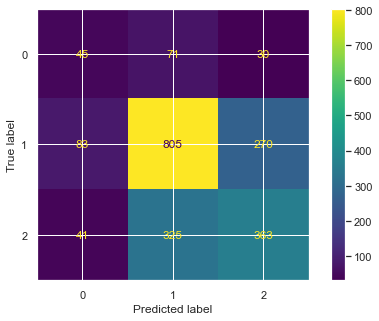

In [56]:
# decision tree
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier()
tree.fit(X_train_df, y_train_ros)

plot_confusion_matrix(tree,X_test_df,y_test);

In [24]:
tree_predictions = tree.predict(X_test_df)
evaluation_metrics(y_test, tree_predictions)

True Neutral prediction accuracy: 0.689119170984456
Predicted Neutral prediction accuracy: 0.6644462947543713
True Negative prediction accuracy: 0.2945205479452055
Predicted Negative prediction accuracy: 0.24571428571428572


0.4734500748495796

## Logistic Regression

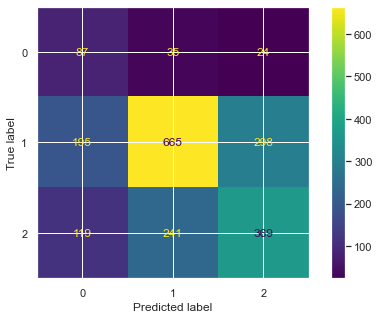

In [25]:
# logistic regression
from sklearn.linear_model import LogisticRegression

# no parameters
log_reg = LogisticRegression(max_iter=500)
log_reg.fit(X_train_df, y_train_ros)
plot_confusion_matrix(log_reg,X_test_df,y_test);

In [26]:
logistic_preds = log_reg.predict(X_test_df)
evaluation_metrics(y_test, logistic_preds)

True Neutral prediction accuracy: 0.57426597582038
Predicted Neutral prediction accuracy: 0.7066950053134963
True Negative prediction accuracy: 0.5958904109589042
Predicted Negative prediction accuracy: 0.2169576059850374


0.5234522495194545

## Multinomial NB

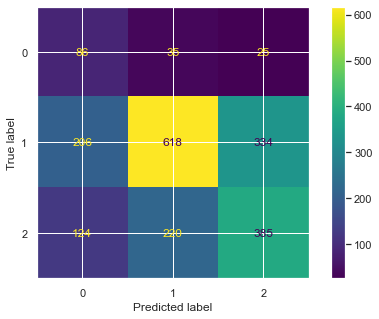

In [27]:
from sklearn.naive_bayes import MultinomialNB
naive = MultinomialNB()
naive.fit(X_train_df,y_train_ros)
plot_confusion_matrix(naive,X_test_df,y_test);

In [28]:
naive_preds = naive.predict(X_test_df)
evaluation_metrics(y_test, naive_preds)

True Neutral prediction accuracy: 0.533678756476684
Predicted Neutral prediction accuracy: 0.7079037800687286
True Negative prediction accuracy: 0.589041095890411
Predicted Negative prediction accuracy: 0.20673076923076922


0.5093386004166481

## SVM

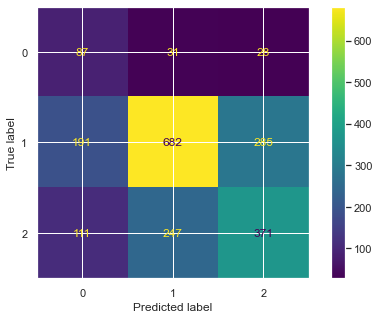

In [29]:
from sklearn.svm import SVC

clf = SVC(kernel='linear')
clf.fit(X_train_df.to_numpy(),y_train_ros)
plot_confusion_matrix(clf,X_test_df.to_numpy(),y_test);

In [30]:
svm_preds = clf.predict(X_test_df.to_numpy())
evaluation_metrics(y_test, svm_preds)

True Neutral prediction accuracy: 0.5889464594127807
Predicted Neutral prediction accuracy: 0.7104166666666667
True Negative prediction accuracy: 0.5958904109589042
Predicted Negative prediction accuracy: 0.2236503856041131


0.5297259806606162

## XGBoost

In [31]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

In [32]:
# Instantiate XGBClassifier
xgboost = XGBClassifier('learning_rate': 0.1,
                        'max_depth': 6,
                        'min_child_weight': 1,
                        'subsample': 0.5,
                        'n_estimators': 100,)

xgboost.fit(X_train_df,y_train_ros)
plot_confusion_matrix(xgboost,X_test_df,y_test);

SyntaxError: invalid syntax (<ipython-input-32-5acbaac338ea>, line 2)

In [ ]:
xgboost_preds = xgboost.predict(X_test_df)
evaluation_metrics(y_test, xgboost_preds)

# Conclusion

# Future Research

# Citations